# Brad Evans: Flame-bait or Lame-bait? (it's a working title, ok?)

[Blurb on why I'm doing this.]

## Methodology

Since Yahoo went with the infinite scrolling UI, pulling up old articles directly from the site became impossible. Thankfully there's Google. Using the following Google search, I can pull back every Flame/Lame call Brad has ever made:

site:sports.yahoo.com/blogs/fantasy-roto-arcade intitle:flames +2012 "Week 10"

site:sports.yahoo.com/blogs/fantasy-roto-arcade intitle:lames +2010 "Week 6"

There is a little manual work involved. Basically, I clicked to the last search result page, and clicked the link that said 

In order to show you the most relevant results, we have omitted some entries very similar to the 85 already displayed.
If you like, you can repeat the search with the omitted results included.

After passing all the captcha tests to prove to google and myself that I was human, I proceeded to Ctrl+A Ctrl+C each page of search results. Google obfuscates URLs, but thankfully, Yahoo's were just the right length for inferrance -

I also used Twitter and Internet Archive: 

flames OR lames @yahoonoise since:2011-01-01 until:2012-01-1

Basically, just use this regex in Vim, and you've got yourself a workable URL. 

:%s/\/\.\.\.\//\/blogs\/fantasy-roto-arcade\//



Yahoo's formats were terribly inconsistent. Bloated. 
Handling Updates.
Brad was a little more fearful early on (2010), suggesting a list of potential flames/lames in addition to his fearless forecasts.
Brad is mostly concerned with flames for 12-man leagues and deaper (prove this)
Under what conditions is Brad usually correct?

SHOCKER SPECIAL
BONUS SHOCKER (2011- week 2)
Attempting to fix missing data by padding with prefixes

Brad definitely didn't make this to be machine readable

A sample of formats (after heavily pre-processed) looks like this:

2009 
Josh Freeman, TB, QB (Noise QB Rank: 11, Start: 12-plus team leagues, 2% started)
Matchup: vs. NO
[WITTY BLURB]
Fearless Forecast: 19-33, 217 passing yards, 2 touchdowns, 1 interception, 24 rushing yards, 19 fantasy points

2010
Thomas Jones, KC, RB (Noise Week 11 RB Rank: 17, 53-percent started)
Matchup: vs. Ari
[WITTY BLURB]
Fearless Forecast: 19 carries, 95 rushing yards, 1 receptions, 4 receiving yards, 1 touchdown, 15 fantasy points

2011
Ben Tate, Hou, RB (Week 3 Noise RB Rank: 9, 22-percent started)
Matchup: at NO
[WITTY BLURB]
Fearless Forecast: 25 carries, 119 rushing yards, 4 receptions, 24 receiving yards, 1 touchdown, 23.3 fantasy points

2011
Michael Vick, Phi, QB (Noise Week 11 QB Rank: 13, 72-percent started)
Matchup: at NYG
[WITTY BLURB]
Fearless Forecast: 17-29, 193 passing yards, 1 touchdown, 2 interceptions, 27 rushing yards, 14.4 fantasy points

2012
Willis McGahee, Den, RB (78-percent started)
Matchup: vs. SD
[WITTY BLURB]
Fearless Forecast: 17 carries, 62 rushing yards, 3 receptions 21 receiving yards, 0 touchdowns, 10.5 fantasy points

2013
Matt Ryan, Atl, QB (53-percent started)
Matchup: at TB
[WITTY BLURB]
Fearless Forecast: 241 passing yards, 1 passing touchdown, 2 interceptions, 5 rushing yards, 14.5 fantasy points

2014
Ben Roethlisberger, Pit, QB (60 percent started)
Matchup: at Ten
[WITTY BLURB]
Fearless Forecast: 25-39, 266 passing yards, 1 passing touchdown, 1 interception, 16.3 fantasy points

2015
Matt Jones, Was, RB (10 percent started, $17)
Matchup: at NYG
[WITTY BLURB]
Fearless Forecast: 13 carries, 66 rushing yards, 3 receptions, 14 receiving yards, 1 touchdown, 15.5 fantasy points

This is fairly consistent now. The major difference going from 2009 to 2015, is in the rank. We start out with a "Noise Rank", and a league depth gague, but eventually just come down to a percent started, and this year, a dollar value added (for FanDuel, no doubt). 

Seeing as how this is Brad, I automatically assume it's geared toward AT LEAST 10 team leagues, but more likely 12. Basically, those in desparation. So I don't need that, nor do I need the out-of-context rank or the week, since we are given that. Dollar value could be interesting, if we were to extend this to daily leagues, so I'll keep that. 

Of course, none of this is easy, as there is no consistency. Sometimes he says the type of rank ("WR Rank") and others, just Rank. Sometimes the percentage is in numeric, other times he spells it out (two-percent). 

Lots of manual work here.

Then there's the Fearless Forecast part. Brad sometimes includes caveats "(Cutler or McCown), (minus Jones)" etc. So I've moved those up to the blurb. Sorry, Brad. Shit or get off the pot. And if you can't make a decision, I'll make one for you.

Year
Player_First_Name Player_Last_Name, Team_Abbreviation, Position (Percent_Started, [Daily_League_Dollar_Amt])
Matchup: [vs.|at] Team_Abbreviation
WITTY_BLURB
Fearless Forecast: [[0-9]*-[0-9]*,] 13 carries, 66 rushing yards, 3 receptions, 14 receiving yards, 1 touchdown, 15.5 fantasy points

Alright, let's start parsing.

For the Fearless Forecast, most of it was pretty consistent, but I took a few liberties. Like in 2009, Brad liked to mark people down for just yards. Not specific yards, like receiving, rushing, or passing. So if it was a WR, I changed it to receiving yards, etc. 

In [2]:
import pprint
import re
from pprint import pprint
import os

from os import listdir
from os.path import isfile, join
from os import walk

import pickle

mypath = '/home/bdetweiler/src/Data Science/brad-evans-analysis/data'
# This is what we're trying to populate
flames_lames_dict = dict()
flame_lame_id = 0

for root, subdirs, files in os.walk(mypath):
    if 'preseason' in root: continue
    if 'free_agent' in root: continue
    for fileName in files:
        if not 'txt' in fileName: continue
        if '.swp' in fileName: continue # happens when editing in Vim
        #if not '2014' in root: continue
        #if not 'week_03' in root: continue
        
        year = float('NaN')
        week = float('NaN')
        flame_lame = ''
        
        m = re.match(".*(20[0-9][0-9])/week_([0-9][0-9])", root)
        if m is not None:
            year = m.group(1)
            week = m.group(2)
        else:
            continue
        
        m = re.match("(flames|lames)\.txt", fileName)
        if m is not None:
            flame_lame = m.group(1)
        
        
        with open(root + '/' + fileName, 'r') as infile:
            data = infile.read()
            my_list = data.splitlines()
            
            player = ''
            matchup = ''
            blurb = ''
            fearless_forecast = ''
            
            # initialize variables
            player_name = ''
            player_team = ''
            player_position = ''
            player_percent_started = float('NaN')
            shocker_special = False

            attempts = float('NaN') 
            carries = float('NaN')
            completions = float('NaN')
            fantasy_points = float('NaN')
            fumbles_lost = float('NaN')
            fumbles_recovered = float('NaN')
            interceptions = float('NaN')
            defensive_interceptions = float('NaN')
            interceptions = float('NaN')
            passing_yards = float('NaN')
            passing_touchdowns = float('NaN')
            points_allowed = float('NaN')
            receiving_yards = float('NaN')
            receptions = float('NaN')
            rushing_touchdowns = float('NaN')
            rushing_yards = float('NaN')
            sacks = float('NaN')
            total_touchdowns = float('NaN')
            turnovers = float('NaN')
            total_yards = float('NaN')
            shocker = False
            
            # Matchup
            home = False
            away = False
            opponent = ''
            
            count = 0
            
            # Date is always first line of file
            date_posted = my_list[0]
            
            # Begin processing file
            for line in my_list:
               
                # we already have the date
                if date_posted in line: continue 
                
                # Skips some of Brad's notes at the end of the file
                if '// Other' in line: continue
                
                if count == 1:
                    player_name = ''
                    player_team = ''
                    player_position = ''
                    player_percent_started = float('NaN')
                    shocker_special = False
                    
                    attempts = float('NaN') 
                    carries = float('NaN')
                    completions = float('NaN')
                    fantasy_points = float('NaN')
                    fumbles_lost = float('NaN')
                    fumbles_recovered = float('NaN')
                    interceptions = float('NaN')
                    defensive_interceptions = float('NaN')
                    interceptions = float('NaN')
                    passing_yards = float('NaN')
                    passing_touchdowns = float('NaN')
                    points_allowed = float('NaN')
                    receiving_yards = float('NaN')
                    receptions = float('NaN')
                    rushing_touchdowns = float('NaN')
                    rushing_yards = float('NaN')
                    sacks = float('NaN')
                    total_touchdowns = float('NaN')
                    turnovers = float('NaN')
                    total_yards = float('NaN')
                    
                    # Matchup
                    home = False
                    away = False
                    opponent = ''
                    
                
                count += 1
                
                if count == 1: continue # Blank new line separator
                elif count == 2:
                    player = line
                    
                    m = re.match("^([A-Za-z\s.\-\']*), ([A-Za-z]*), ([A-Z/]*) \(([0-9]*)[%]?\)(, SHOCKER SPECIAL)?", player)
                    if m is not None:
                        if m.group(1) is not None:
                            player_name = m.group(1)
                            player_team = m.group(2)
                            player_position = m.group(3)
                            if m.group(4) is not None:
                                try:
                                    player_percent_started = float(m.group(4)) * .01
                                except (ValueError):
                                    player_percent_started = float('NaN')
                            if m.group(5) is not None:
                                shocker_special = True
                            else:
                                shocker_special = False


                    continue
                    
                elif count == 3:
                    matchup = line
                        
                    m = re.match("Matchup: (vs\.|at) ([A-Za-z]*)", matchup)
                    if m is not None:
                        if m.group(1) == 'vs.':
                            home = True
                        else:
                            away = True
                    
                        opponent = m.group(2)

                            
                    continue
                    
                elif count == 4:
                    blurb = line

                    continue
                    
                elif count == 5:
                    fearless_forecast = line

                        
                    m = re.match("Fearless Forecast: (([0-9]*) (carries))", fearless_forecast)
                    if m is not None:
                        carries = m.group(2)
        
                    m = re.match(".*(( ([0-9]+\.[0-9]+))|( ([0-9]+)) fantasy points)", fearless_forecast)
                    if m is not None:
                        if m.group(3) is not None:
                            fantasy_points = m.group(3)
                        elif m.group(5) is not None:
                            fantasy_points = m.group(5)

                    m = re.match("Fearless Forecast: ([0-9]+)-([0-9]+),", fearless_forecast)
                    if m is not None:
                        completions = m.group(1)
                        attempts = m.group(2)
                    
                    m = re.match(".*, ([0-9]+) fumble recovery", fearless_forecast)
                    if m is not None:
                        fumbles_recovered = m.group(1)
                        
                    m = re.match(".* ([0-9]+) fumble lost", fearless_forecast)
                    if m is not None:
                        fumbles_lost = m.group(1)

                    m = re.match(".* ([0-9]+) interception", fearless_forecast)
                    if m is not None:
                        interceptions = m.group(1)
                    
                    m = re.match(".* ([0-9]+) defensive interception", fearless_forecast)
                    if m is not None:
                        defensive_interceptions = m.group(1)
                        
                    m = re.match(".* ([0-9]+) passing yards", fearless_forecast)
                    if m is not None:
                        passing_yards = m.group(1)
                        
                    m = re.match(".* ([0-9]+) passing touchdown", fearless_forecast)
                    if m is not None:
                        passing_touchdowns = m.group(1)
                            
                    m = re.match(".* ([0-9]+) points allowed", fearless_forecast)
                    if m is not None:
                        points_allowed = m.group(1)

                    m = re.match(".* ([0-9]+) receiving yards", fearless_forecast)
                    if m is not None:
                        receiving_yards = m.group(1)
                        
                    m = re.match(".* ([0-9]+) receptions", fearless_forecast)
                    if m is not None:
                        receptions = m.group(1)

                    m = re.match(".* ([0-9]+) rushing touchdown", fearless_forecast)
                    if m is not None:
                        rushing_touchdowns = m.group(1)

                    m = re.match(".* ([0-9]+) rushing yards", fearless_forecast)
                    if m is not None:
                        rushing_yards = m.group(1)

                    m = re.match(".* ([0-9]+) sack", fearless_forecast)
                    if m is not None:
                        sacks = m.group(1)
                        
                    m = re.match(".* ([0-9]+) total touchdown", fearless_forecast)
                    if m is not None:
                        total_touchdowns = m.group(1)
                    
                    m = re.match(".* ([0-9]+) turnovers", fearless_forecast)
                    if m is not None:
                        turnovers = m.group(1)

                    m = re.match(".* ([0-9]+) total yards", fearless_forecast)
                    if m is not None:
                        total_yards = m.group(1)
                    
                    continue
                    
                count = 1

                flames_lames_dict[flame_lame_id] = {
                    "year": year,
                    "week": week,
                    "date_posted": date_posted,
                    "flame_lame": flame_lame,
                    "player_name": player_name,
                    "player_team": player_team,
                    "player_position": player_position,
                    "player_percent_started": player_percent_started,
                    "shocker_special": shocker_special,
                    
                    "attempts": attempts,
                    "carries": carries,
                    "completions": completions,
                    "fantasy_points": fantasy_points,
                    "fumbles_lost": fumbles_lost,
                    "fumbles_recovered": fumbles_recovered,
                    "interceptions": interceptions,
                    "defensive_interceptions": defensive_interceptions,
                    "interceptions": interceptions,
                    "passing_yards": passing_yards,
                    "passing_touchdowns": passing_touchdowns,
                    "points_allowed": points_allowed,
                    "receiving_yards": receiving_yards,
                    "receptions": receptions,
                    "rushing_touchdowns": rushing_touchdowns,
                    "rushing_yards": rushing_yards,
                    "sacks": sacks,
                    "total_touchdowns": total_touchdowns,
                    "turnovers": turnovers,
                    "total_yards": total_yards,
                    
                    "home": home,
                    "away": away,
                    "opponent": opponent,
                    "blurb": blurb
                }
                
                flame_lame_id += 1

pickle.dump( flames_lames_dict, open( "/home/bdetweiler/src/Data Science/brad-evans-analysis/data/flames_lames.p", "wb" ) )
target = open('/home/bdetweiler/src/Data Science/brad-evans-analysis/data/flames_lames.dict', 'w')
target.write(str(flames_lames_dict))
target.close()



Now all of the scrubbed data is in a nice, usable dict. Let's do some preliminary data exploration.

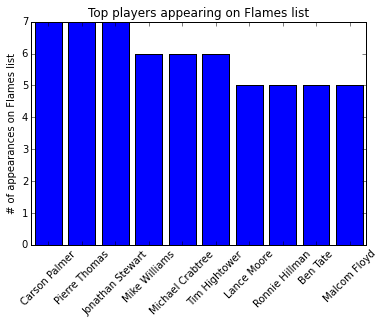

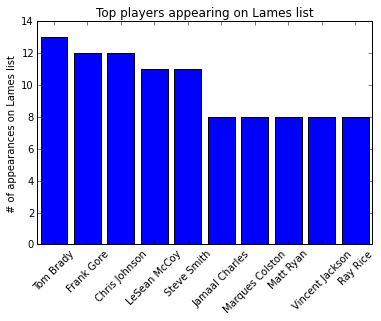

In [3]:
%matplotlib inline
from collections import Counter
from matplotlib import pyplot as plt


flames_lames = pickle.load(open("flames_lames.p", "rb"))

flames_players = []
lames_players = []

for key in flames_lames:
    if flames_lames[key]['flame_lame'] == 'flames':
        flames_players.append(flames_lames[key]['player_name'])
    if flames_lames[key]['flame_lame'] == 'lames':
        lames_players.append(flames_lames[key]['player_name'])

flames_players.sort()
lames_players.sort()

flames_player_name = []
flames_player_count = []

flames_count = Counter(flames_players)

for name, count in flames_count.most_common(10):
    flames_player_name.append(name)
    flames_player_count.append(count)
    
lames_player_name = []
lames_player_count = []
lames_count = Counter(lames_players)

for name, count in lames_count.most_common(10):
    lames_player_name.append(name)
    lames_player_count.append(count)

xs = [i + 0.1 for i, _ in enumerate(flames_player_name)]
plt.bar(xs, flames_player_count)
plt.ylabel('# of appearances on Flames list')
plt.title('Top players appearing on Flames list')
plt.xticks([i + 0.5 for i, _ in enumerate(flames_player_name)], flames_player_name)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

plt.show()

xs = [i + 0.1 for i, _ in enumerate(lames_player_name)]
plt.bar(xs, lames_player_count)
plt.ylabel('# of appearances on Lames list')
plt.title('Top players appearing on Lames list')
plt.xticks([i + 0.5 for i, _ in enumerate(lames_player_name)], lames_player_name)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

plt.show()
    

Man, Brad hates Tom Brady. But really, who doesn't? And I've felt like he's always had it out for Chris Johnson (CJ2LAME if I remember correctly), but wasn't he kind of an easy target? At least after 2012 anyway. So that's kinda cool. What about players who appeared on both lists? Does Brad flipflop? 

Carson Palmer has 8 appearances
Darren Sproles has 8 appearances
Pierre Thomas has 9 appearances
LeSean McCoy has 13 appearances
Jamaal Charles has 10 appearances
Knowshon Moreno has 8 appearances
Chris Johnson has 13 appearances
Mike Williams has 8 appearances
Michael Crabtree has 8 appearances
Matt Ryan has 9 appearances
Rashard Mendenhall has 9 appearances
Ryan Mathews has 11 appearances
Steve Smith has 13 appearances
Philip Rivers has 9 appearances
Ben Roethlisberger has 9 appearances
Marshawn Lynch has 9 appearances


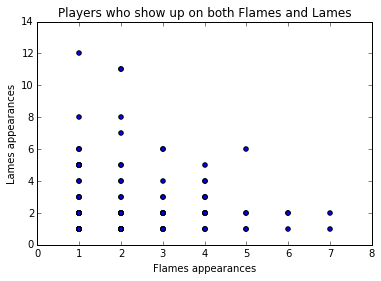

In [4]:
flames_and_lames = set(flames_players).intersection(lames_players)

flames_and_lames_flames_count = []
flames_and_lames_lames_count = []


total_count = 0
for name in flames_and_lames:
    total_count_player = 0
    for flame_name, count in flames_count.most_common():
        if flame_name == name:
            flames_and_lames_flames_count.append(count)
            total_count += count
            total_count_player += count
    for lame_name, count in lames_count.most_common():
        if lame_name == name:
            flames_and_lames_lames_count.append(count)
            total_count += count
            total_count_player += count
    if (total_count_player > 7):
        print(name + ' has ' + str(total_count_player) + ' appearances')

plt.scatter(flames_and_lames_flames_count, flames_and_lames_lames_count)

plt.title("Players who show up on both Flames and Lames")
plt.xlabel('Flames appearances')
plt.ylabel('Lames appearances')

plt.show()

Now it's probably time to grab some NFL data. I was expecting this to be next to impossible, in an automated fashion, but the NFL website is slightly more accommodating than I initially presumed.

Since I'm only interested in player data, and we're only going back to 2009, that makes our search a little more finite.

We begin at the player stats page, located here: http://www.nfl.com/stats/categorystats?tabSeq=1&statisticPositionCategory=QUARTERBACK&season=2015&seasonType=REG

I grab each page with wget. For example, 

wget 'http://www.nfl.com/stats/categorystats?archive=true&conference=null&statisticPositionCategory=QUARTERBACK&season=2009&seasonType=REG&experience=&tabSeq=1&qualified=false&Submit=Go' -O QB_2009_1.txt
wget 'http://www.nfl.com/stats/categorystats?tabSeq=1&season=2009&seasonType=REG&experience=&Submit=Go&archive=true&d-447263-p=2&conference=null&statisticPositionCategory=QUARTERBACK&qualified=false' -O QB_2009_2.txt

Now that we've got all these index pages, we have links to all the players

cat QB_20\* | grep profile?id | sed -e 's/^[ \t]*//g; s/a href="/www.nfl.com/; s/".*//g; s/<//g' | sort | uniq > qb_all.html
cat RB_20\* | grep profile?id | sed -e 's/^[ \t]*//g; s/a href="/www.nfl.com/; s/".*//g; s/<//g' | sort | uniq > rb_all.html
cat TE_20\* | grep profile?id | sed -e 's/^[ \t]*//g; s/a href="/www.nfl.com/; s/".*//g; s/<//g' | sort | uniq > te_all.html
cat WR_20\* | grep profile?id | sed -e 's/^[ \t]*//g; s/a href="/www.nfl.com/; s/".*//g; s/<//g' | sort | uniq > wr_all.html
cat K_20\* | grep profile?id | sed -e 's/^[ \t]*//g; s/a href="/www.nfl.com/; s/".*//g; s/<//g' | sort | uniq > k_all.html

...exception they are redirects. For example,
www.nfl.com/players/brandonweeden/profile?id=WEE221487
redirects to
http://www.nfl.com/player/brandonweeden/2532970/profile

So we need to grab those...

wget -i qb_all.html --max-redirect=0 2>&1 > /dev/null | grep Location | sed -e 's/Location: /www\.nfl\.com/; s/\ .*//g; s/profile/gamelogs/' | sort | uniq > qb_final.txt
wget -i rb_all.html --max-redirect=0 2>&1 > /dev/null | grep Location | sed -e 's/Location: /www\.nfl\.com/; s/\ .*//g; s/profile/gamelogs/' | sort | uniq > rb_final.txt
wget -i wr_all.html --max-redirect=0 2>&1 > /dev/null | grep Location | sed -e 's/Location: /www\.nfl\.com/; s/\ .*//g; s/profile/gamelogs/' | sort | uniq > wr_final.txt
wget -i te_all.html --max-redirect=0 2>&1 > /dev/null | grep Location | sed -e 's/Location: /www\.nfl\.com/; s/\ .*//g; s/profile/gamelogs/' | sort | uniq > te_final.txt
wget -i k_all.html --max-redirect=0 2>&1 > /dev/null | grep Location | sed -e 's/Location: /www\.nfl\.com/; s/\ .*//g; s/profile/gamelogs/' | sort | uniq > k_final.txt


Now we've got a direct link to all each player's stats. But we're not out of the woods yet. We need to pull all those down, and then parse those individual files. 

I wrote a shell script that iterates over qb_final.txt and pulls down all the data files:



This does a pretty fantastic job. Remarkably, the NFL does not throttle or do any kind of gatekeeping. I was able to hammer their website with no protest. Thanks, NFL! (The only time you'll hear me say that.)

Now, we've got the raw HTML files, but we need this in some sort of usable format. I like Tab Separated Values, so we'll try to convert to that. The following is a very ugly glued-together script THAT WORKS. I'm not going for style point shere.

Note that ^M is the linefeed character commonly seen in the Microsoft world, but it can give us a lot of headaches if we don't get rid of it up front.

This gives us a new set of files with just the table data. One more step to go to get it in a nice tab-separated values format.




Now we have everything in TSVs. The next step is to get this all into a database so we can query it!

We'll be using SQLite since it's portable. Here is the schema we'll be using: [INSERT SCHEMA HERE]



In [1]:
from storm.locals import *
import csv
import re
from pprint import pprint
import os
import math

from os import listdir
from os.path import isfile, join
from os import walk

class Player(object):
    __storm_table__ = "PLAYER"
    PLAYER_ID = Int(primary=True)
    FIRST_NAME = Unicode()
    MIDDLE_NAME = Unicode()
    LAST_NAME = Unicode()
    NAME_SUFFIX = Unicode()
    HEIGHT = Float()
    WEIGHT = Float()
    BIRTH_DATE = Date()
    BIRTH_CITY = Unicode()
    BIRTH_STATE = Unicode()
    BIRTH_COUNTRY = Unicode()
    HIGH_SCHOOL_NAME = Unicode()
    HIGH_SCHOOL_CITY = Unicode()
    HIGH_SCHOOL_STATE = Unicode()
    COLLEGE = Unicode()
    
    def __init__(self, player_id, first_name, middle_name, last_name, name_suffix, height, weight, birth_date, birth_city, birth_state, birth_country, high_school_name, high_school_city, high_school_state, college):
        self.PLAYER_ID = int(player_id)
        self.FIRST_NAME = u'' + first_name
        self.MIDDLE_NAME = u'' + middle_name
        self.LAST_NAME = u'' + last_name
        self.NAME_SUFFIX = u'' + name_suffix
        self.HEIGHT = float(height)
        self.WEIGHT = float(weight)
        
        if (birth_date != ''):
            self.BIRTH_DATE = birth_date
            
        self.BIRTH_CITY = u'' + birth_city
        self.BIRTH_STATE = u'' + birth_state
        self.BIRTH_COUNTRY = u'' + birth_country
        self.HIGH_SCHOOL_NAME = u'' + high_school_name
        self.HIGH_SCHOOL_CITY = u'' + high_school_city
        self.HIGH_SCHOOL_STATE = u'' + high_school_state
        self.COLLEGE = u'' + college
        

    def __str__(self):
        return 'Player[ PLAYER_ID = ' + str(player_id) + ', FIRST_NAME = ' + first_name + ', MIDDLE_NAME = ' + middle_name + ', LAST_NAME = ' + last_name + ', NAME_SUFFIX = ' + name_suffix + ', HEIGHT = ' + str(height) + ', WEIGHT = ' + str(weight) + ', BIRTH_DATE = ' +  str(birth_date) + ', BIRTH_CITY = ' + birth_city + ', BIRTH_STATE = ' + birth_state + ', BIRTH_COUNTRY = ' + birth_country + ', HIGH_SCHOOL_NAME = ' + high_school_name + ', HIGH_SCHOOL_CITY = ' + high_school_city + ', HIGH_SCHOOL_STATE = ' + high_school_state + ', COLLEGE = ' + college + ' ]'

class Team(object):
    __storm_table__ = "TEAM"
    TEAM_ID = Unicode(primary=True)
    TEAM_ABBRV = Unicode()
    LONG_NAME = Unicode()
    CONFERENCE = Unicode()
    DIVISION = Unicode()
    def __init__(self, team_id, team_abbrv, long_name, conference, division):
        self.TEAM_ID = team_id
        self.TEAM_ABBRV = team_abbrv
        self.LONG_NAME = long_name
        self.CONFERENCE = conference
        self.DIVISION = division
    
    def verbose_team_name(team_name):
        if(team_name.lower() == 'Buccaneers') or (team_name.lower() == 'TB'):
            return 'Tampa Bay Buccaneers'
        if(team_name.lower() == 'Vikings') or (team_name.lower() == 'MIN'):
            return 'Minnesota Vikings'
        if(team_name.lower() == 'Jets') or (team_name.lower() == 'NYJ'):
            return 'New York Jets'
        if(team_name.lower() == 'Texans') or (team_name.lower() == 'HOU'):
            return 'Houston Texans'
        if(team_name.lower() == 'Bears') or (team_name.lower() == 'CHI'):
            return 'Chicago Bears'
        if(team_name.lower() == 'Cowboys') or (team_name.lower() == 'DAL'):
            return 'Dallas Cowboys'
        if(team_name.lower() == 'Buccaneers') or (team_name.lower() == 'TB'):
            return 'Tampa Bay Buccaneers'
        if(team_name.lower() == 'Buccaneers') or (team_name.lower() == 'TB'):
            return 'Tampa Bay Buccaneers'
        if(team_name.lower() == 'Bengals') or (team_name.lower() == 'CIN'):
            return 'Cincinnatti Bengals'
        if(team_name.lower() == '49ers') or (team_name.lower() == 'SF'):
            return 'San Francisco 49ers'
        if(team_name.lower() == 'Bills') or (team_name.lower() == 'BUF'):
            return 'Buffalo Bills'
        if(team_name.lower() == 'Broncos') or (team_name.lower() == 'DEN'):
            return 'Denver Broncos'
        if(team_name.lower() == 'Browns') or (team_name.lower() == 'CLE'):
            return 'Cleveland Browns'
        if(team_name.lower() == 'Cardinals') or (team_name.lower() == 'ARI'):
            return 'Arizona Cardinals'
        if(team_name.lower() == 'Chargers') or (team_name.lower() == 'SD'):
            return 'San Diego Chargers'
        if(team_name.lower() == 'Chiefs') or (team_name.lower() == 'KC'):
            return 'Kansas City Chiefs'
        if(team_name.lower() == 'Colts') or (team_name.lower() == 'IND'):
            return 'Indianapolis Colts'
        if(team_name.lower() == 'Dolphins') or (team_name.lower() == 'MIA'):
            return 'Miami Dolphins'
        if(team_name.lower() == 'Eagles') or (team_name.lower() == 'PHI'):
            return 'Philadelphia Eagles'
        if(team_name.lower() == 'Falcons') or (team_name.lower() == 'ATL'):
            return 'Atlanta Falcons'
        if(team_name.lower() == 'Giants') or (team_name.lower() == 'NYG'):
            return 'New York Giants'
        if(team_name.lower() == 'Jaguars') or (team_name.lower() == 'JAX'):
            return 'Jacksonville Jaguars'
        if(team_name.lower() == 'Lions') or (team_name.lower() == 'DET'):
            return 'Detroit Lions'
        if(team_name.lower() == 'Oilers') or (team_name.lower() == 'OIL'):
            return 'Houston Oilers'
        if(team_name.lower() == 'Packers') or (team_name.lower() == 'GB'):
            return 'Green Bay Packers'
        if(team_name.lower() == 'Panthers') or (team_name.lower() == 'CAR'):
            return 'Carolina Panthers'
        if(team_name.lower() == 'Patriots') or (team_name.lower() == 'NE'):
            return 'New England Patriots'
        if(team_name.lower() == 'Raiders') or (team_name.lower() == 'OAK'):
            return 'Oakland Raiders'
        if(team_name.lower() == 'Rams') or (team_name.lower() == 'STL'):
            return 'St. Louis Rams'
        if(team_name.lower() == 'Ravens') or (team_name.lower() == 'BAL'):
            return 'Baltimore Ravens'
        if(team_name.lower() == 'Redskins') or (team_name.lower() == 'WAS'):
            return 'Washington Redskins'
        if(team_name.lower() == 'Saints') or (team_name.lower() == 'NO'):
            return 'New Orleans Saints'
        if(team_name.lower() == 'Seahawks') or (team_name.lower() == 'SEA'):
            return 'Seattle Seahawks'
        if(team_name.lower() == 'Steelers') or (team_name.lower() == 'PIT'):
            return 'Pittsburgh Steelers'
        if(team_name.lower() == 'Titans') or (team_name.lower() == 'TEN'):
            return 'Tennessee Titans'
    def __str__(self):
        return 'Team[ TEAM_ID = ' + str(self.TEAM_ID) + ', Team_ABBRV = ' + self.TEAM_ABBRV + ', LONG_NAME = ' + self.LONG_NAME + ', CONFERENCE = ' + self.CONFERENCE + ', DIVISION = ' + self.DIVISION + ']'
    
    
class Game(object):
    __storm_table__ = "GAME"
    GAME_ID = Int(primary=True)
    SEASON = Unicode()
    YEAR = Int()
    WEEK = Unicode()
    HOME_TEAM = Unicode()
    VISITING_TEAM = Unicode()
    HOME_TEAM_SCORE = Int()
    VISITING_TEAM_SCORE = Int()
    HOME_TEAM_RESULT = Unicode()
    VISITING_TEAM_RESULT = Unicode()
    GAME_DATE = Date()
    DAY_OF_WEEK = Unicode()
    POST_SEASON_TYPE = Unicode()
    
    def __init__(self, game_id, season, year, week, home_team, visiting_team, home_team_score, visiting_team_score, home_team_result, visiting_team_result, game_date, day_of_week, post_season_type):

        self.GAME_ID = int(game_id)

        self.SEASON = u'' + season

        self.YEAR = int(year)

        # I screwed up and set week as a varchar
        self.WEEK = u'' + str(week)

        self.HOME_TEAM = u'' + home_team
        self.VISITING_TEAM = u'' + visiting_team
        
        if(isinstance(home_team_score, float) == False):
            home_team_score = float(home_team_score)
        if (math.isnan(home_team_score) == False):
            self.HOME_TEAM_SCORE = int(home_team_score)

        if(isinstance(visiting_team_score, float) == False):
            visiting_team_score = float(visiting_team_score)
        if (math.isnan(visiting_team_score) == False):
            self.VISITING_TEAM_SCORE = int(visiting_team_score)

        self.HOME_TEAM_RESULT = u'' + home_team_result
        self.VISITING_TEAM_RESULT = u'' + visiting_team_result
        
        if(game_date != ''):
            self.GAME_DATE = game_date

        self.DAY_OF_WEEK = u'' + day_of_week
        if (post_season_type != ''):
            self.POST_SEASON_TYPE = u'' + post_season_type

    def __str__(self):
        return 'Game[ GAME_ID = ' + str(self.GAME_ID) + ', SEASON = ' + str(self.SEASON) + ', YEAR = ' + str(self.YEAR) + ', WEEK = ' + str(self.WEEK) + ', HOME_TEAM = ' + str(self.HOME_TEAM) + ', AWAY_TEAM = ' + str(self.VISITING_TEAM) + ', HOME_TEAM_RESULT = ' + str(self.HOME_TEAM_RESULT) + ', VISITING_TEAM_RESULT = ' + str(self.VISITING_TEAM_RESULT) + ', GAME_DATE = ' + str(self.GAME_DATE) + ', DAY_OF_WEEK = ' + str(self.DAY_OF_WEEK) + ', POST_SEASON_TYPE = ' + str(self.POST_SEASON_TYPE) + ']'


        
        
class Roster(object):
    __storm_table__ = "ROSTER"
    ROSTER_ID = Int(primary=True)
    TEAM_ID = Unicode()
    GAME_ID = Int()
    game = Reference(GAME_ID, Game.GAME_ID)
    team = Reference(TEAM_ID, Team.TEAM_ID)
    
    def __init__(self, roster_id, team_id, game_id):
        self.ROSTER_ID = int(roster_id)
        self.TEAM_ID = u'' + team_id
        self.GAME_ID = int(game_id)
        
    def __str__(self):
        return 'Roster[ ROSTER_ID = ' + str(self.GAME_ID) + ', SEASON = ' + str(self.SEASON) + ', YEAR = ' + str(self.YEAR) + ', WEEK = ' + str(self.WEEK) + ', HOME_TEAM = ' + str(self.HOME_TEAM) + ', AWAY_TEAM = ' + str(self.VISITING_TEAM) + ', HOME_TEAM_RESULT = ' + str(self.HOME_TEAM_RESULT) + ', VISITING_TEAM_RESULT = ' + str(self.VISITING_TEAM_RESULT) + ', GAME_DATE = ' + str(self.GAME_DATE) + ', DAY_OF_WEEK = ' + str(self.DAY_OF_WEEK) + ', POST_SEASON_TYPE = ' + str(self.POST_SEASON_TYPE) + ']'        

class Stats(object):
    __storm_table__ = "PLAYER_STATS"
    
    PLAYER_STATS_ID = Int(primary=True) 
    PLAYER_ID = Int()
    ROSTER_ID = Int()
    GAME_PLAYED = Unicode()
    GAME_STARTED = Unicode()
    PASS_COMPLETED = Int()
    PASS_ATTEMPTED = Int()
    PASS_PERCENTAGE = Float()
    PASS_YARDS = Float()
    PASS_AVERAGE_YARDS = Float()
    PASS_TD = Int()
    PASS_INT = Int()
    PASS_SACK = Int()
    PASS_SACK_YARDS = Float()
    PASS_RATING   = Float()
    RUSH_ATTEMPTS = Int()
    RUSH_YARDS = Float()
    RUSH_AVERAGE = Float()
    RUSH_LONG = Float()
    RUSH_TD = Int()
    FUMBLES = Int()
    FUMBLES_LOST = Int()
    RECEIVING_RECEPTIONS = Int()
    RECEIVING_YARDS = Float()
    RECEIVING_AVERAGE = Float()
    RECEIVING_LONG = Float()
    RECEIVING_TD = Int()
    FG_BLOCKED = Int()
    FG_LONG = Float()
    FG_ATTEMPTS = Int()
    FG_MADE = Int()
    FG_PERCENT = Float()
    XP_MADE = Int()
    XP_ATTEMPTS = Int()
    XP_PERCENT = Float()
    XP_BLOCKED = Int()
    KICKOFFS = Int()
    KICKOFFS_AVERAGE = Float()
    KICKOFFS_TOUCHBACKS = Int()
    KICKOFFS_RETURNED = Int()
    KICKOFFS_AVERAGE = Float()

    player = Reference(PLAYER_ID, Player.PLAYER_ID)
    roster = Reference(ROSTER_ID, Roster.ROSTER_ID)
    
    def __init__(self, player_stats_id, player_id, roster_id, game_result, game_played, game_started, pass_completed, pass_attempted, pass_percentage, pass_yards, pass_average_yards, pass_td, pass_int, pass_sack, pass_sack_yards, pass_rating, rush_attempts, rush_yards, rush_average, rush_long, rush_td, fumbles, fumbles_lost, receiving_receptions, receiving_yards, receiving_average, receiving_long, receiving_td, fg_blocked, fg_long, fg_attempts, fg_made, fg_percent, xp_made, xp_attempts, xp_percent, xp_blocked, kickoffs, kickoffs_average, kickoffs_touchbacks, kickoffs_returned):
        self.PLAYER_STATS_ID = int(player_stats_id)
        self.PLAYER_ID = int(player_id)
        self.ROSTER_ID = int(roster_id)
        self.GAME_PLAYED = u'' + game_played
        self.GAME_STARTED = u'' + game_started
        
        # Passing
        self.PASS_COMPLETED = int(pass_completed)
        self.PASS_ATTEMPTED = int(pass_attempted)
        self.PASS_PERCENTAGE = float(pass_percentage)
        self.PASS_YARDS = float(pass_yards)
        self.PASS_AVERAGE_YARDS = float(pass_average_yards)
        self.PASS_TD = int(pass_td)
        self.PASS_INT = int(pass_int)
        self.PASS_SACK = int(pass_sack)
        self.PASS_SACK_YARDS = float(pass_sack_yards)
        self.PASS_RATING = float(pass_rating)
        
        # Rushing
        self.RUSH_ATTEMPTS = int(rush_attempts)
        self.RUSH_YARDS = float(rush_yards)
        self.RUSH_AVERAGE = float(rush_average)
        self.RUSH_LONG = float(rush_long)
        self.RUSH_TD = int(rush_td)
        self.FUMBLES = int(fumbles)
        self.FUMBLES_LOST = int(fumbles_lost)
        
        # Receiving
        self.RECEIVING_RECEPTIONS = int(receiving_receptions)
        self.RECEIVING_YARDS = float(receiving_yards)
        self.RECEIVING_AVERAGE = float(receiving_average)
        self.RECEIVING_LONG = float(receiving_long)
        self.RECEIVING_TD = int(receiving_td)
        
        # Field Goals
        self.FG_BLOCKED = int(fg_blocked)
        self.FG_LONG = float(fg_long)
        self.FG_ATTEMPTS = int(fg_attempts)
        self.FG_MADE = int(fg_made)
        self.FG_PERCENT = float(fg_percent)
        
        # Extra Points
        self.XP_MADE = int(xp_made)
        self.XP_ATTEMPTS = int(xp_attempts)
        self.XP_PERCENT = float(xp_percent)
        self.XP_BLOCKED = int(xp_blocked)
        
        # Kickoffs
        self.KICKOFFS = int(kickoffs)
        self.KICKOFFS_AVERAGE = float(kickoffs_average)
        self.KICKOFFS_TOUCHBACKS = int(kickoffs_touchbacks)
        self.KICKOFFS_RETURNED = int(kickoffs_returned)


        
#database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/nfl.db")
#store = Store(database)


# store.execute("CREATE TABLE PLAYER (PLAYER_ID INTEGER PRIMARY KEY, PLAYER_ID INTEGER, FIRST_NAME VARCHAR, MIDDLE_NAME VARCHAR, LAST_NAME VARCHAR, NAME_SUFFIX VARCHAR, HEIGHT FLOAT, WEIGHT FLOAT, BIRTH_DATE DATE, BIRTH_CITY VARCHAR, BIRTH_STATE VARCHAR, BIRTH_COUNTRY VARCHAR, COLLEGE VARCHAR, HIGH_SCHOOL VARCHAR, HIGH_SCHOOL_CITY VARCHAR, HIGH_SCHOOL_STATE VARCHAR)")
# store.execute("CREATE TABLE PLAYER_STATS (PLAYER_STATS_ID INTEGER PRIMARY KEY, PLAYER_ID INTEGER, ROSTER_ID INTEGER, GAME_RESULT VARCHAR, GAME_PLAYED VARCHAR, GAME_STARTED VARCHAR, PASS_COMPLETED INTEGER, PASS_ATTEMPTED INTEGER, PASS_PERCENTAGE INTEGER, PASS_YARDS INTEGER, PASS_AVERAGE_YARDS INTEGER, PASS_TD INTEGER, PASS_INT INTEGER, PASS_SACK INTEGER, PASS_SACK_YARDS INTEGER, PASS_RATING INTEGER, RUSH_ATTEMPTS INTEGER, RUSH_YARDS INTEGER, RUSH_AVERAGE INTEGER, RUSH_LONG INTEGER, RUSH_TD INTEGER, FUMBLES INTEGER, FUMBLES_LOST INTEGER, RECEIVING_RECEPTIONS INTEGER, RECEIVING_YARDS INTEGER, RECEIVING_AVERAGE INTEGER, RECEIVING_LONG INTEGER, RECEIVING_TD INTEGER, FG_BLOCKED INTEGER, FG_LONG INTEGER, FG_ATTEMPTS INTEGER, FG_MADE INTEGER, FG_PERCENT INTEGER, XP_MADE INTEGER, XP_ATTEMPTS INTEGER, XP_PERCENT INTEGER, XP_BLOCKED INTEGER, KICKOFFS INTEGER, KICKOFFS_AVERAGE INTEGER, KICKOFFS_TOUCHBACKS INTEGER, KICKOFFS_RETURNED INTEGER, FOREIGN KEY(PLAYER_ID) REFERENCES PLAYER(PLAYER_ID), FOREIGN KEY(ROSTER_ID) REFERENCES ROSTER(ROSTER_ID))") 
# store.execute("CREATE TABLE ROSTER (ROSTER_ID INTEGER PRIMARY KEY, TEAM_ID VARCHAR, GAME_ID INTEGER, FOREIGN KEY(TEAM_ID) REFERENCES TEAM(TEAM_ID), FOREIGN KEY(GAME_ID) REFERENCES GAME)")
# store.execute("CREATE TABLE GAME (GAME_ID INTEGER PRIMARY KEY, SEASON VARCHAR, YEAR INTEGER, WEEK VARCHAR, HOME_TEAM VARCHAR, VISITING_TEAM VARCHAR, HOME_TEAM_SCORE INTEGER, VISITING_TEAM_SCORE INTEGER, HOME_TEAM_RESULT VARCHAR, VISITING_TEAM_RESULT VARCHAR, DAY_OF_WEEK VARCHAR, GAME_DATE DATE, POST_SEASON_TYPE VARCHAR)")

#store.add(Team(u"Baltimore Ravens", u"BAL", u"AFC", u"N"))
#store.add(Team(u"Cincinnati Bengals", u"CIN", u"AFC", u"N"))
#store.add(Team(u"Cleveland Browns", u"CLE", u"AFC", u"N"))
#store.add(Team(u"Pittsburgh Steelers", u"PIT", u"AFC", u"N"))

#store.add(Team(u"Houston Texans", u"HOU", u"AFC", u"S"))
#store.add(Team(u"Indianapolis Colts", u"IND", u"AFC", u"S"))
#store.add(Team(u"Jacksonville Jaguars", u"JAX", u"AFC", u"S"))
#store.add(Team(u"Tennessee Titans", u"TEN", u"AFC", u"S"))

#store.add(Team(u"Buffalo Bills", u"BUF", u"AFC", u"E"))
#store.add(Team(u"Miami Dolphins", u"MIA", u"AFC", u"E"))
#store.add(Team(u"New England Patriots", u"NE", u"AFC", u"E"))
#store.add(Team(u"New York Jets", u"NYJ", u"AFC", u"E"))

#store.add(Team(u"Denver Broncos", u"DEN", u"AFC", u"W"))
#store.add(Team(u"Kansas City Chiefs", u"KC", u"AFC", u"W"))
#store.add(Team(u"Oakland Raiders", u"OAK", u"AFC", u"W"))
#store.add(Team(u"San Diego Chargers", u"SD", u"AFC", u"W"))

#store.add(Team(u"Chicago Bears", u"CHI", u"NFC", u"N"))
#store.add(Team(u"Detroit Lions", u"DET", u"NFC", u"N"))
#store.add(Team(u"Green Bay Packers", u"GB", u"NFC", u"N"))
#store.add(Team(u"Minnesota Vikings", u"MIN", u"NFC", u"N"))

#store.add(Team(u"Atlanta Falcons", u"ATL", u"NFC", u"S"))
#store.add(Team(u"Carolina Panthers", u"CAR", u"NFC", u"S"))
#store.add(Team(u"New Orleans Saints", u"NO", u"NFC", u"S"))
#store.add(Team(u"Tampa Bay Buccaneers", u"TB", u"NFC", u"S"))

#store.add(Team(u"Dallas Cowboys", u"DAL", u"NFC", u"E"))
#store.add(Team(u"New York Giants", u"NYG", u"NFC", u"E"))
#store.add(Team(u"Philadelphia Eagles", u"PHI", u"NFC", u"E"))
#store.add(Team(u"Washington Redskins", u"WAS", u"NFC", u"E"))

#store.add(Team(u"Arizona Cardinals", u"ARI", u"NFC", u"W"))
#store.add(Team(u"San Francisco 49ers", u"SF", u"NFC", u"W"))
#store.add(Team(u"Seattle Seahawks", u"SEA", u"NFC", u"W"))
#store.add(Team(u"St. Louis Rams", u"STL", u"NFC", u"W"))



#team = store.find(Team, Team.TEAM_ID == u"Dallas Cowboys").one()   
#print "%r, %r" % (team.TEAM_ID, team.TEAM_ABBRV)



In [6]:
from storm.locals import *
import csv
import re
from pprint import pprint
import os
import datetime

from os import listdir
from os.path import isfile, join
from os import walk
from dateutil.parser import parse


mypath = '/home/bdetweiler/src/Data Science/Brad Evans Raw Data/NFL/games/'

game_id = 0


        
#database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/nfl.db")
#store = Store(database)


for root, subdirs, files in os.walk(mypath):
    for fileName in files:
        
        year = float('NaN')
        week = float('NaN')
        month = ''
        day = float('NaN')
        day_of_week = ''
        game_date = ''
        home_team = ''
        away_team = ''
        home_score = float('NaN')
        away_score = float('NaN')
        home_result = ''
        away_result = ''
        post_season_type = ''
        season = 'REG'
        pre = False
        post = False
        
        if '.txt' not in fileName: continue
            
        m = re.match("^([1-2][0-9]*)_.*", fileName)
        if m is not None:
            year = m.group(1)
            
        m = re.match("^[1-2][0-9]*_REG([0-9]+).*", fileName)
        n = re.match("^[1-2][0-9]*_PRE([0-9]+).*", fileName)
        if m is not None:
            week = m.group(1)
        elif n is not None:
            week = n.group(1)
            pre = True
            season = 'PRE'
        else:
            post = True
            season = 'POST'
        
        # print(fileName)
        
        # Go through each file
        #with open(root + '/' + fileName, 'r') as infile:
        #    data = infile.read()
        #    my_list = data.splitlines()
            
        #    for line in my_list:
        #        game_id += 1
        #        m = re.match("(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)", line)
        #        if m is not None:
                    # print(line)
        #            day_of_week = m.group(1)
                    
        #            m = re.match(".*(August|September|October|November|December|January|February)", line)
        #            if m is not None:
        #                month = m.group(1)
                        
        #            m = re.match(".*([0-9][0-9])", line)
        #            if m is not None:
        #                day = m.group(1)
                                    
        #            game_date = datetime.datetime.strptime(month + ' ' + day + ', ' + year + ' ' + '00:00:00', "%B %d, %Y %H:%M:%S")
                    
        #            continue;
                
                
                
        #        m = re.match("WildCardWeekend", line)
        #        if m is not None:
        #            post_season_type = 'Wild Card'
        #            continue;
                    
        #        m = re.match("DivisionalPlayoffs", line)
        #        if m is not None:
        #            post_season_type = 'Divisional Playoffs'
        #            continue;
            
        #        m = re.match("ConferenceChampionships", line)
        #        if m is not None:
        #            post_season_type = 'Conference Championships'
        #            continue;
            
        #        m = re.match("ProBowl", line)
        #        if m is not None:
        #            post_season_type = 'Pro Bowl'
        #            continue;
                    
        #        m = re.match("SuperBowl", line)
        #        if m is not None:
        #            post_season_type = 'Super Bowl'
        #            continue;
                    
        #        m = re.match("((AFC)|(NFC)|[A-Z][a-z]+|49ers)-([0-9][0-9])-([0-9][0-9])-(AFC|NFC|[A-Z][a-z]+|49ers)", line)
        #        if m is not None:
        #            home_team = m.group(4)
        #            away_team = m.group(1)
        #            home_score = m.group(3)
        #            away_score = m.group(2)
                
        #        if (home_score > away_score):
        #            home_result = 'W'
        #            away_result = 'L'
        #        elif (home_score < away_score):
        #            home_result = 'L'
        #            away_result = 'W'
        #        else: 
        #            home_result = 'T'
        #            away_result = 'T'
                    
        #        game = Game(game_id, season, year, week, home_team, away_team, home_score, away_score, home_result, away_result, game_date, day_of_week, post_season_type)
                
        #        store.add(Game(game_id, season, year, week, home_team, away_team, home_score, away_score, home_result, away_result, game_date, day_of_week, post_season_type))

                

        #game_date = ''
        #home_team = ''
        #away_team = ''
        #home_score = float('NaN')
        #away_score = float('NaN')
        #post_season_type = ''
        #pre = False
        #post = False
        
        #with open(root + '/' + fileName,'rb') as tsvin:
        #    tsvin = csv.reader(tsvin, delimiter='\t')
        #    m = re.match("([a-z]*)_([0-9]*)_(20[0-9][0-9])", fileName)
        #    if m is not None:
        #        player = m.group(1)
        #        player_id = m.group(2)
        #        year = m.group(3)
        
            # WEEK	GAME_DATE	OPPONENT	RESULT	GAME_PLAYED	GAME_STARTED	PASS_COMPLETED	PASS_ATTEMPTED	PASS_PERCENTAGE	PASS_YARDS	PASS_AVERAGE_YARDS	PASS_TD	PASS_INT	PASS_SACK	PASS_SACK_YARDS	PASS_RATING	RUSH_ATTEMPTS	RUSH_ATTEMPTS	RUSH_AVERAGE	RUSH_TD	FUMBLES	FUMBLES_LOST
        #    for row in tsvin:
        #        week = int(row[0])
        #        m = re.match("([0-9][0-9])/([0-9][0-9])", row[1])
        #        if m is not None:
        #            month = m.group(1)
        #            day = m.group(2)
        #        m = re.match("@", row[2])
        #        home_away = ''
        #        if m is not None:
        #            month = m.group(1)
        #            day = m.group(2)

        #with open(root + '/' + fileName,'rb') as tsvin:
        #    tsvin = csv.reader(tsvin, delimiter='\t')
        #    m = re.match("([a-z]*)_([0-9]*)_(20[0-9][0-9])", fileName)
        #    if m is not None:
        #        player = m.group(1)
        #        player_id = m.group(2)
        #        year = m.group(3)
        
            # WEEK	GAME_DATE	OPPONENT	RESULT	GAME_PLAYED	GAME_STARTED	PASS_COMPLETED	PASS_ATTEMPTED	PASS_PERCENTAGE	PASS_YARDS	PASS_AVERAGE_YARDS	PASS_TD	PASS_INT	PASS_SACK	PASS_SACK_YARDS	PASS_RATING	RUSH_ATTEMPTS	RUSH_ATTEMPTS	RUSH_AVERAGE	RUSH_TD	FUMBLES	FUMBLES_LOST
        #    for row in tsvin:
        #        week = int(row[0])
        #        m = re.match("([0-9][0-9])/([0-9][0-9])", row[1])
        #        if m is not None:
        #            month = m.group(1)
        #            day = m.group(2)
        #        m = re.match("@", row[2])
        #        home_away = ''
        #        if m is not None:
        #            month = m.group(1)
        #            day = m.group(2)
#store.flush()
#store.commit()


In [41]:
from dateutil.parser import parse

    
mypath = '/home/bdetweiler/src/Data Science/Brad Evans Raw Data/NFL/players/'


        
#database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/nfl.db")
#store = Store(database)


for root, subdirs, files in os.walk(mypath):
    for fileName in files:
        
        first_name = ''
        middle_name = ''
        last_name = ''
        name_suffix = ''
        compact_name = ''
        player_id = int(0)
        height = float(0)
        height_feet = float(0)
        height_inches = float(0)
        weight = float(0)
        
        birth_day = int(0)
        birth_month = int(0)
        birth_year = int(0)
        birth_date = ''
        
        birth_city = ''
        birth_state = ''
        birth_country = ''
        
        high_school_name = ''
        high_school_city = ''
        high_school_state = ''
        
        college = ''
        
        if 'table' not in fileName: continue
        
        m = re.match("(^[a-z]+)_.*", fileName)
        if m is not None:
            compact_name = m.group(1)
        
        m = re.match("^[a-z]+_([0-9]+).*", fileName)
        if m is not None:
            player_id = int(m.group(1))
        
        with open(root + '/' + fileName, 'r') as infile:
            count = 1
            data = infile.read()
            my_list = data.splitlines()
            
            for line in my_list:

                m = re.match("^Height: ([0-9]+)-([0-9]+)", line)
                if m is not None:
                    
                    height_feet = float(m.group(1))
                    height_inches = float(m.group(2))                    
                    height = float(height_feet) + float(height_inches / 12)
                    continue
                    
                m = re.match("^Weight: ([0-9]+)", line)
                if m is not None:
                    weight = float(m.group(1))
                    continue
                    
                m = re.match("^Age: ([0-9]+)", line)
                if m is not None:
                    # Don't need this
                    # age = float(m.group(1))
                    continue
                    
                m = re.match("^Born: ([0-9]+)/([0-9]+)/([0-9]+)", line)
                if m is not None:
                    birth_month = int(m.group(1))
                    birth_day = int(m.group(2))
                    birth_year = int(m.group(3))
                    birth_month_str = str(birth_month)
                    birth_day_str = str(birth_day)

                    # Zero pad
                    if (len(birth_month_str) == 1):
                        birth_month_str = '0' + birth_month_str;
                    # Zero pad
                    if (len(birth_day_str) == 1):
                        birth_day_str = '0' + birth_day_str;
                        
                    birth_date = datetime.datetime.strptime(birth_month_str + '/' + birth_day_str + '/' + str(birth_year), "%m/%d/%Y")
                    continue
                    
                m = re.match("^College: (.*)", line)
                if m is not None:
                    college = m.group(1)
                    continue
                    
                m = re.match("^High School: (.*)", line)
                if m is not None:
                    high_school_name = m.group(1)
                    continue
                    
                m = re.match("([A-Za-z .'-]+) ([A-Za-z .'-]+)", line)
                if m is not None:
                    first_name = m.group(1)
                    last_name = m.group(2)
                    middle_name = ''
                    name_suffix = ''
                    continue
                
#               store.add(Player(player_id, first_name, middle_name, last_name, name_suffix, height, weight, birth_date, birth_city, birth_state, birth_country, high_school_name, high_school_city, high_school_state, college))

                
#store.flush()
#store.commit()


--------------------- ryanlongwell_2501792.html_table.txt ---------------------------
--------------------- ryanlongwell_2501792.html_table.txt ---------------------------
--------------------- ryanlongwell_2501792.html_table.txt ---------------------------
--------------------- ryanlongwell_2501792.html_table.txt ---------------------------
--------------------- ryanlongwell_2501792.html_table.txt ---------------------------
--------------------- ryanlongwell_2501792.html_table.txt ---------------------------
--------------------- ryanlongwell_2501792.html_table.txt ---------------------------
--------------------- anthonysherman_2495340.html_table.txt ---------------------------
--------------------- anthonysherman_2495340.html_table.txt ---------------------------
--------------------- anthonysherman_2495340.html_table.txt ---------------------------
--------------------- anthonysherman_2495340.html_table.txt ---------------------------
--------------------- anthonysherman_2495340.h

In [2]:
from storm.locals import *
import csv
import re
from pprint import pprint
import os
import datetime

from os import listdir
from os.path import isfile, join
from os import walk
from dateutil.parser import parse

#### Insert all rosters 
database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/nfl.db")
store = Store(database)

games = store.find(Game)

roster_id = 0
for game in games:
    roster_id += 1
    store.add(Roster(roster_id, game.HOME_TEAM, game.GAME_ID))
    roster_id += 1
    store.add(Roster(roster_id, game.VISITING_TEAM, game.GAME_ID))

print('committing...')
store.flush()
store.commit()

committing...


In [2]:
##### Insert QBs

from storm.locals import *
import csv
import re
from pprint import pprint
import os
import datetime

from os import listdir
from os.path import isfile, join
from os import walk
from dateutil.parser import parse


mypath = '/home/bdetweiler/src/Data Science/Brad Evans Raw Data/NFL/QB/'

        
database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/nfl.db")
store = Store(database)

player_stats_id = 0
    
for root, subdirs, files in os.walk(mypath):
    for fileName in files:
        
        
        first_name = ''
        middle_name = ''
        last_name = ''
        name_suffix = ''
        compact_name = ''
        player_id = int(0)
        height = float(0)
        height_feet = float(0)
        height_inches = float(0)
        weight = float(0)
        
        birth_day = int(0)
        birth_month = int(0)
        birth_year = int(0)
        birth_date = ''
        
        birth_city = ''
        birth_state = ''
        birth_country = ''
        
        high_school_name = ''
        high_school_city = ''
        high_school_state = ''
        
        college = ''
        
        if 'tsv' not in fileName: continue
        if 'header.tsv' in fileName: continue
        if 'tsv.sh' in fileName: continue

        m = re.match("^[a-z'.-]+_([0-9]+)_([1-2][0-9]+).tsv", fileName)
        if m is not None:
            player_id = int(m.group(1))
            year = int(m.group(2))
        
            #print(str(player_id) + ' - ' + str(year))
        
        
        with open(root + '/' + fileName, 'r') as tsvin:
            count = 1

            team = None
            game = None
                        
            tsvin = csv.reader(tsvin, delimiter='\t')
            

            print(fileName)
            
            for line in tsvin:
                #print('--------------------- ' + fileName + ' ---------------------------')
                if (len(line) == 0): continue
                
                #print(line)
                
                opponent_team = None
                
                player_stats_id += 1
                pass_completed = int(0)
                pass_attempted = int(0)
                pass_percentage = float(0)
                pass_yards = float(0)
                pass_average_yards = float(0)
                pass_td = int(0)
                pass_int = int(0)
                pass_sack = int(0)
                pass_sack_yards = float(0)
                pass_rating = float(0)
                rush_attempts  = int(0)
                rush_yards = float(0)
                rush_average = float(0)
                rush_long  = float(0)
                rush_td = int(0)
                fumbles = int(0)
                fumbles_lost = int(0)
                receiving_receptions = int(0)
                receiving_yards = float(0)
                receiving_average = float(0)
                receiving_long = float(0)
                receiving_td = int(0)
                fg_blocked = int(0)
                fg_long = float(0)
                fg_attempts = int(0)
                fg_made = int(0)
                fg_percent = float(0)
                xp_made = int(0)
                xp_attempts = int(0)
                xp_percent = float(0)
                xp_blocked = int(0)
                kickoffs = int(0)
                kickoffs_average = float(0)
                kickoffs_touchbacks = int(0)
                kickoffs_returned = int(0)
                week = int(line[0])

                m = re.match("^([0-9][0-9])/([0-9][0-9])", line[1])
                if m is not None:
                    month = m.group(1)
                    day = m.group(2)
                    game_date = datetime.datetime.strptime(str(month) + '/' + str(day) + '/' + str(year), "%m/%d/%Y")

                away = False
                opponent = ''
                m = re.match("^@.*", line[2])
                if m is not None:
                    away = True
                    n = re.match("^@(.*)", line[2])
                    if n is not None:
                        opponent = n.group(1)
                else:
                    opponent = line[2]

                #print ('opponent line[2] = ' + line[2])
                if (opponent == 'JAC'):
                    opponent = 'JAX'
                    
                if (opponent == 'NPR'):
                    opponent = 'NFC'
                

                if opponent_team is None:
                    #print('looking for opponent, ' + opponent)
                    opponent_team = store.find(Team, Team.TEAM_ABBRV == unicode(opponent)).one()
                    #print("select * from team where team_abbrv = '" + opponent + "';")
                    #test = store.execute("select * from team where team_abbrv = '" + opponent + "';").get_one()
                    #print(test)
                    #print(opponent_team)
                else:
                    print(opponent)
                    print('could not get opponent team')
                    
                # Had trouble with dates, but this works, so...
                if (opponent_team is not None):
                    #game = store.find(Game, And(Game.GAME_DATE == game_date, Game.HOME_TEAM == opponent_team.TEAM_ID)).one()
                    
                    #print('opponent_team = ' + opponent_team.TEAM_ID + ', game_date = ' + str(game_date))
                    
                    if (away):
                        #print('looking up game by date [' + str(game_date) + '] and home_team = [' + opponent_team.TEAM_ID + ']')
                        #my_game = store.execute("SELECT * FROM GAME WHERE GAME_DATE = '" + str(game_date) + "' AND HOME_TEAM = '" + str(opponent_team.TEAM_ID) + "'").get_one()
                        #print('my_game = ' + str(my_game))
                        
                        
                        game = store.find(Game, And(Game.GAME_DATE == game_date, Game.HOME_TEAM == opponent_team.TEAM_ID)).one()
                        #print('game (visitor) = ')
                        #print(game)
                        #print(team)
                        
                        team = store.find(Team, Team.TEAM_ID == u'' + game.VISITING_TEAM).one()
                        game_result = game.VISITING_TEAM_RESULT
                    else:
                        
                        #my_game = store.execute("SELECT * FROM GAME WHERE GAME_DATE = '" + str(game_date.strftime('%Y-%m-%d')) + "' AND VISITING_TEAM = '" + str(opponent_team.TEAM_ID) + "'").get_one()
                        #print('my_game = ' + str(my_game))
                        #print('looking up game by date [' + str(game_date) + '] and visiting_team = [' + opponent_team.TEAM_ID + ']')
                        
                        # XXX: Not finding Colts, 2013-01-11
                        game = store.find(Game, And(Game.GAME_DATE == game_date, Game.VISITING_TEAM == opponent_team.TEAM_ID)).one()
                        #print('game (home) = ')
                        #print(game)
                        

                        #store.find(Team, Team.TEAM_ID == u'' + game.VISITING_TEAM).one()

                        #print(game)
                        #print('hometeam = ' + str(game.HOME_TEAM))
                        #team = store.execute("SELECT * FROM TEAM WHERE TEAM_ID = '" + str(game.HOME_TEAM) + "'").get_one()

                        #print(team)
                        team = store.find(Team, Team.TEAM_ID == u'' + game.HOME_TEAM).one()
                        game_result = game.HOME_TEAM_RESULT

                if (line[4] != '--') and (line[4] != ''):
                    game_played = str(line[4])
                    
                if (line[5] != '--') and (line[5] != ''):
                    game_started = str(line[5])
                
                if (line[6] != '--') and (line[6] != ''):
                    pass_completed = int(line[6])
                    
                if (line[7] != '--') and (line[7] != ''):
                    pass_attempted = int(line[7])
                    
                if (line[8] != '--') and (line[8] != ''):
                    pass_percentage = float(line[8])
                
                if (line[9] != '--') and (line[9] != ''):
                    pass_yards = float(line[9])
                    
                if (line[10] != '--') and (line[10] != ''):
                    pass_average = float(line[10])
                    
                if (line[11] != '--') and (line[11] != ''):
                    pass_td = int(line[11])
                    
                if (line[12] != '--') and (line[12] != ''):
                    pass_interceptions = int(line[12])
                    
                if (line[13] != '--') and (line[13] != ''):
                    pass_sacks = int(line[13])
                    
                if (line[14] != '--') and (line[14] != ''):
                    pass_sack_yards = float(line[14])
                    
                if (line[15] != '--') and (line[15] != ''):
                    pass_rating = float(line[15])
                    
                if (line[16] != '--') and (line[16] != ''):
                    rush_attempts = int(line[16])
                    
                if (line[17] != '--') and (line[17] != ''):
                    rush_yards = float(line[17])
                    
                if (line[18] != '--') and (line[18] != ''):
                    rush_average = float(line[18])
                
                if (line[19] != '--') and (line[19] != ''):
                    rush_td = int(line[19])
                    
                if (line[20] != '--') and (line[20] != ''):
                    rush_fum = int(line[20])
                    
                if (line[21] != '--') and (line[21] != ''):
                    rush_fum_lost = int(line[21])
                
                #pass_completed = int(0)
                #pass_attempted = int(0)
                #pass_percentage = float(0)
                #pass_yards = float(0)
                #pass_average_yards = float(0)
                ##pass_td = int(0)
                #pass_int = int(0)
                #pass_sack = int(0)
                #pass_sack_yards = float(0)
                #pass_rating = float(0)
                #rush_attempts  = int(0)
                #rush_yards = float(0)
                #rush_average = float(0)
                #rush_long  = float(0)
                #rush_td = int(0)
                #fumbles = int(0)
                #fumbles_lost = int(0)
                receiving_receptions = int(0)
                receiving_yards = float(0)
                receiving_average = float(0)
                receiving_long = float(0)
                receiving_td = int(0)
                fg_blocked = int(0)
                fg_long = float(0)
                fg_attempts = int(0)
                fg_made = int(0)
                fg_percent = float(0)
                xp_made = int(0)
                xp_attempts = int(0)
                xp_percent = float(0)
                xp_blocked = int(0)
                kickoffs = int(0)
                kickoffs_average = float(0)
                kickoffs_touchbacks = int(0)
                kickoffs_returned = int(0)
                
                
                #roster = store.find(Roster, And(Team.TEAM_ID == team.TEAM_ID, Game.GAME_ID == game.GAME_ID)).one()
                
                roster = store.find(Roster, And(Roster.TEAM_ID == team.TEAM_ID, Roster.GAME_ID == game.GAME_ID)).one()
                
                #for roster in rosters:
                # print('for team_id ' + team.TEAM_ID + ' and game_id = ' + str(game.GAME_ID))
                
                if (roster is None):
                    print('roster not found for TEAM ' + team.TEAM_ID + ' and game ' + game.GAME_ID)
                

                stats = Stats(player_stats_id, player_id, roster.ROSTER_ID, game_result, u'' + game_played, game_started, pass_completed, pass_attempted, pass_percentage, pass_yards, pass_average_yards, pass_td, pass_int, pass_sack, pass_sack_yards, pass_rating, rush_attempts, rush_yards, rush_average, rush_long, rush_td, fumbles, fumbles_lost, receiving_receptions, receiving_yards, receiving_average, receiving_long, receiving_td, fg_blocked, fg_long, fg_attempts, fg_made, fg_percent, xp_made, xp_attempts, xp_percent, xp_blocked, kickoffs, kickoffs_average, kickoffs_touchbacks, kickoffs_returned)
                
                store.add(stats)


                #m = re.match("^Height: ([0-9]+)-([0-9]+)", line)
                #if m is not None:
                    
                #    height_feet = float(m.group(1))
                #    height_inches = float(m.group(2))                    
                #    height = float(height_feet) + float(height_inches / 12)
                #    continue
    
#               store.add(Player(player_id, first_name, middle_name, last_name, name_suffix, height, weight, birth_date, birth_city, birth_state, birth_country, high_school_name, high_school_city, high_school_state, college))


print('committing...')
store.flush()
store.commit()


drewstanton_2495748_2014.tsv
philiprivers_2506121_2011.tsv
donovanmcnabb_2502044_2010.tsv
stephenmcgee_81296_2013.tsv
stephenmcgee_81296_2011.tsv
scotttolzien_2495425_2011.tsv
dominiquedavis_2532829_2012.tsv
christianponder_2495215_2014.tsv
russellwilson_2532975_2014.tsv
billyvolek_2503939_2011.tsv
joshjohnson_264_2015.tsv
brianst.pierre_2505604_2010.tsv
joshmccown_2505076_2015.tsv
mattcassel_2506562_2009.tsv
joshmccown_2505076_2014.tsv
mattcassel_2506562_2011.tsv
charliebatch_2499567_2011.tsv
joeflacco_382_2015.tsv
jakelocker_2495194_2013.tsv
tonyromo_2505354_2014.tsv
daunteculpepper_2500249_2009.tsv
chasedaniel_81284_2012.tsv
mattschaub_2505982_2013.tsv
ryannassib_2539961_2013.tsv
philiprivers_2506121_2012.tsv
ryanfitzpatrick_2506581_2011.tsv
blainegabbert_2495441_2011.tsv
billyvolek_2503939_2010.tsv
johnbeck_2507171_2012.tsv
timtebow_497135_2012.tsv
joeflacco_382_2010.tsv
charliebatch_2499567_2012.tsv
curtispainter_81300_2012.tsv
jonkitna_2501630_2009.tsv
davidcarr_2504804_2009.tsv


Note: Terrell Pryor is marked as a WR on the NFL website, even though he played QB for a while.

In [ ]:
### Insert WRs

from storm.locals import *
import csv
import re
from pprint import pprint
import os
import datetime

from os import listdir
from os.path import isfile, join
from os import walk
from dateutil.parser import parse


mypath = '/home/bdetweiler/src/Data Science/Brad Evans Raw Data/NFL/WR/'

        
database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/nfl.db")
store = Store(database)

player_stats_id = 0
    
for root, subdirs, files in os.walk(mypath):
    for fileName in files:
        
        
        first_name = ''
        middle_name = ''
        last_name = ''
        name_suffix = ''
        compact_name = ''
        player_id = int(0)
        height = float(0)
        height_feet = float(0)
        height_inches = float(0)
        weight = float(0)
        
        birth_day = int(0)
        birth_month = int(0)
        birth_year = int(0)
        birth_date = ''
        
        birth_city = ''
        birth_state = ''
        birth_country = ''
        
        high_school_name = ''
        high_school_city = ''
        high_school_state = ''
        
        college = ''
        
        if 'tsv' not in fileName: continue
        if 'header.tsv' in fileName: continue
        if 'tsv.sh' in fileName: continue

        m = re.match("^[a-z'.-]+_([0-9]+)_([1-2][0-9]+).tsv", fileName)
        if m is not None:
            player_id = int(m.group(1))
            year = int(m.group(2))
        
            #print(str(player_id) + ' - ' + str(year))
        
        
        with open(root + '/' + fileName, 'r') as tsvin:
            count = 1

            team = None
            game = None
                        
            tsvin = csv.reader(tsvin, delimiter='\t')
            

            print(fileName)
            
            for line in tsvin:
                #print('--------------------- ' + fileName + ' ---------------------------')
                if (len(line) == 0): continue
                
                #print(line)
                
                opponent_team = None
                
                player_stats_id += 1
                pass_completed = int(0)
                pass_attempted = int(0)
                pass_percentage = float(0)
                pass_yards = float(0)
                pass_average_yards = float(0)
                pass_td = int(0)
                pass_int = int(0)
                pass_sack = int(0)
                pass_sack_yards = float(0)
                pass_rating = float(0)
                rush_attempts  = int(0)
                rush_yards = float(0)
                rush_average = float(0)
                rush_long  = float(0)
                rush_td = int(0)
                fumbles = int(0)
                fumbles_lost = int(0)
                receiving_receptions = int(0)
                receiving_yards = float(0)
                receiving_average = float(0)
                receiving_long = float(0)
                receiving_td = int(0)
                fg_blocked = int(0)
                fg_long = float(0)
                fg_attempts = int(0)
                fg_made = int(0)
                fg_percent = float(0)
                xp_made = int(0)
                xp_attempts = int(0)
                xp_percent = float(0)
                xp_blocked = int(0)
                kickoffs = int(0)
                kickoffs_average = float(0)
                kickoffs_touchbacks = int(0)
                kickoffs_returned = int(0)
                week = int(line[0])

                m = re.match("^([0-9][0-9])/([0-9][0-9])", line[1])
                if m is not None:
                    month = m.group(1)
                    day = m.group(2)
                    game_date = datetime.datetime.strptime(str(month) + '/' + str(day) + '/' + str(year), "%m/%d/%Y")

                away = False
                opponent = ''
                m = re.match("^@.*", line[2])
                if m is not None:
                    away = True
                    n = re.match("^@(.*)", line[2])
                    if n is not None:
                        opponent = n.group(1)
                else:
                    opponent = line[2]

                #print ('opponent line[2] = ' + line[2])
                if (opponent == 'JAC'):
                    opponent = 'JAX'
                    
                if (opponent == 'NPR'):
                    opponent = 'NFC'
                

                if opponent_team is None:
                    #print('looking for opponent, ' + opponent)
                    opponent_team = store.find(Team, Team.TEAM_ABBRV == unicode(opponent)).one()
                    #print("select * from team where team_abbrv = '" + opponent + "';")
                    #test = store.execute("select * from team where team_abbrv = '" + opponent + "';").get_one()
                    #print(test)
                    #print(opponent_team)
                else:
                    print(opponent)
                    print('could not get opponent team')
                    
                # Had trouble with dates, but this works, so...
                if (opponent_team is not None):
                    #game = store.find(Game, And(Game.GAME_DATE == game_date, Game.HOME_TEAM == opponent_team.TEAM_ID)).one()
                    
                    #print('opponent_team = ' + opponent_team.TEAM_ID + ', game_date = ' + str(game_date))
                    
                    if (away):
                        #print('looking up game by date [' + str(game_date) + '] and home_team = [' + opponent_team.TEAM_ID + ']')
                        #my_game = store.execute("SELECT * FROM GAME WHERE GAME_DATE = '" + str(game_date) + "' AND HOME_TEAM = '" + str(opponent_team.TEAM_ID) + "'").get_one()
                        #print('my_game = ' + str(my_game))
                        
                        
                        game = store.find(Game, And(Game.GAME_DATE == game_date, Game.HOME_TEAM == opponent_team.TEAM_ID)).one()
                        #print('game (visitor) = ')
                        #print(game)
                        #print(team)
                        
                        team = store.find(Team, Team.TEAM_ID == u'' + game.VISITING_TEAM).one()
                        game_result = game.VISITING_TEAM_RESULT
                    else:
                        
                        #my_game = store.execute("SELECT * FROM GAME WHERE GAME_DATE = '" + str(game_date.strftime('%Y-%m-%d')) + "' AND VISITING_TEAM = '" + str(opponent_team.TEAM_ID) + "'").get_one()
                        #print('my_game = ' + str(my_game))
                        #print('looking up game by date [' + str(game_date) + '] and visiting_team = [' + opponent_team.TEAM_ID + ']')
                        
                        # XXX: Not finding Colts, 2013-01-11
                        game = store.find(Game, And(Game.GAME_DATE == game_date, Game.VISITING_TEAM == opponent_team.TEAM_ID)).one()
                        #print('game (home) = ')
                        #print(game)
                        

                        #store.find(Team, Team.TEAM_ID == u'' + game.VISITING_TEAM).one()

                        #print(game)
                        #print('hometeam = ' + str(game.HOME_TEAM))
                        #team = store.execute("SELECT * FROM TEAM WHERE TEAM_ID = '" + str(game.HOME_TEAM) + "'").get_one()

                        #print(team)
                        team = store.find(Team, Team.TEAM_ID == u'' + game.HOME_TEAM).one()
                        game_result = game.HOME_TEAM_RESULT

                if (line[4] != '--') and (line[4] != ''):
                    game_played = str(line[4])
                    
                if (line[5] != '--') and (line[5] != ''):
                    game_started = str(line[5])
                
                if (line[6] != '--') and (line[6] != ''):
                    pass_completed = int(line[6])
                    
                if (line[7] != '--') and (line[7] != ''):
                    pass_attempted = int(line[7])
                    
                if (line[8] != '--') and (line[8] != ''):
                    pass_percentage = float(line[8])
                
                if (line[9] != '--') and (line[9] != ''):
                    pass_yards = float(line[9])
                    
                if (line[10] != '--') and (line[10] != ''):
                    pass_average = float(line[10])
                    
                if (line[11] != '--') and (line[11] != ''):
                    pass_td = int(line[11])
                    
                if (line[12] != '--') and (line[12] != ''):
                    pass_interceptions = int(line[12])
                    
                if (line[13] != '--') and (line[13] != ''):
                    pass_sacks = int(line[13])
                    
                if (line[14] != '--') and (line[14] != ''):
                    pass_sack_yards = float(line[14])
                    
                if (line[15] != '--') and (line[15] != ''):
                    pass_rating = float(line[15])
                    
                if (line[16] != '--') and (line[16] != ''):
                    rush_attempts = int(line[16])
                    
                if (line[17] != '--') and (line[17] != ''):
                    rush_yards = float(line[17])
                    
                if (line[18] != '--') and (line[18] != ''):
                    rush_average = float(line[18])
                
                if (line[19] != '--') and (line[19] != ''):
                    rush_td = int(line[19])
                    
                if (line[20] != '--') and (line[20] != ''):
                    rush_fum = int(line[20])
                    
                if (line[21] != '--') and (line[21] != ''):
                    rush_fum_lost = int(line[21])
                
                pass_completed = int(0)
                pass_attempted = int(0)
                pass_percentage = float(0)
                pass_yards = float(0)
                pass_average_yards = float(0)
                pass_td = int(0)
                pass_int = int(0)
                pass_sack = int(0)
                pass_sack_yards = float(0)
                pass_rating = float(0)
                #rush_attempts  = int(0)
                #rush_yards = float(0)
                #rush_average = float(0)
                #rush_long  = float(0)
                #rush_td = int(0)
                #fumbles = int(0)
                #fumbles_lost = int(0)
                #receiving_receptions = int(0)
                #receiving_yards = float(0)
                #receiving_average = float(0)
                #receiving_long = float(0)
                #receiving_td = int(0)
                fg_blocked = int(0)
                fg_long = float(0)
                fg_attempts = int(0)
                fg_made = int(0)
                fg_percent = float(0)
                xp_made = int(0)
                xp_attempts = int(0)
                xp_percent = float(0)
                xp_blocked = int(0)
                kickoffs = int(0)
                kickoffs_average = float(0)
                kickoffs_touchbacks = int(0)
                kickoffs_returned = int(0)
                
                
                #roster = store.find(Roster, And(Team.TEAM_ID == team.TEAM_ID, Game.GAME_ID == game.GAME_ID)).one()
                
                roster = store.find(Roster, And(Roster.TEAM_ID == team.TEAM_ID, Roster.GAME_ID == game.GAME_ID)).one()
                
                #for roster in rosters:
                # print('for team_id ' + team.TEAM_ID + ' and game_id = ' + str(game.GAME_ID))
                
                if (roster is None):
                    print('roster not found for TEAM ' + team.TEAM_ID + ' and game ' + game.GAME_ID)
                

                stats = Stats(player_stats_id, player_id, roster.ROSTER_ID, game_result, u'' + game_played, game_started, pass_completed, pass_attempted, pass_percentage, pass_yards, pass_average_yards, pass_td, pass_int, pass_sack, pass_sack_yards, pass_rating, rush_attempts, rush_yards, rush_average, rush_long, rush_td, fumbles, fumbles_lost, receiving_receptions, receiving_yards, receiving_average, receiving_long, receiving_td, fg_blocked, fg_long, fg_attempts, fg_made, fg_percent, xp_made, xp_attempts, xp_percent, xp_blocked, kickoffs, kickoffs_average, kickoffs_touchbacks, kickoffs_returned)
                
                store.add(stats)


                #m = re.match("^Height: ([0-9]+)-([0-9]+)", line)
                #if m is not None:
                    
                #    height_feet = float(m.group(1))
                #    height_inches = float(m.group(2))                    
                #    height = float(height_feet) + float(height_inches / 12)
                #    continue
    
#               store.add(Player(player_id, first_name, middle_name, last_name, name_suffix, height, weight, birth_date, birth_city, birth_state, birth_country, high_school_name, high_school_city, high_school_state, college))


print('committing...')
#store.flush()
#store.commit()
